## This notebook scrapes content from wikipedia to prepare a dataframe containing the neighbourhood and borough information of the city of Toronto, Canada. It further adds additional geographical information

In [1]:
# Use one of the following to install BeautifulSoup even though we may not use it.
!pip install --upgrade BeautifulSoup4
#!conda install -c conda-forge BeautifulSoup4 --yes 

Requirement already up-to-date: BeautifulSoup4 in c:\software\anaconda3\lib\site-packages (4.9.1)


In [2]:
!pip install geocoder

In [3]:
!pip install geopy

In [4]:
!pip install folium

##### various import statements

In [5]:
import numpy as np
import pandas as pd

import json
import sklearn
from IPython.display import Image
from sklearn.tree import export_graphviz
from IPython.display import HTML, display

import urllib.request as urlreq

from bs4 import BeautifulSoup

from geopy.geocoders import Nominatim

import requests 
from pandas.io.json import json_normalize

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

import seaborn as sbn
sbn.set_style("white")
sbn.set_palette("RdGy_r")
sbn.set_context('talk')

import matplotlib
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

## Data Extraction from Wikipedia

In [6]:
wikipedia_toronto_postal_codes = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
#wikipedia_toronto_postal_codes = "https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&oldid=945633050"
#wikipedia_toronto_additional_neighbourhoods = "https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Toronto"

#### Read the Wikipedia page for listing by postal code

In [7]:
wikipedia_content_list_by_postalcode = pd.read_html(wikipedia_toronto_postal_codes)
wikipedia_content_by_postalcode_df  = pd.DataFrame(wikipedia_content_list_by_postalcode, columns = ['table_content'])
display(wikipedia_content_by_postalcode_df.head())
print(wikipedia_content_by_postalcode_df.shape)

,table_content
0,Postal Code Borough \ 0 ...
1,...
2,0 1 2 3 4 5 6 7 8 9 10 ...


(3, 1)


In [8]:
toronto_neighbourhood_by_postalcode_as_read_df = wikipedia_content_by_postalcode_df['table_content'].values[0]
toronto_neighbourhood_by_postalcode_as_read_df.columns = ['postalcode','borough','neighbourhood']
toronto_neighbourhood_by_postalcode_as_read_df.sort_values(['borough','neighbourhood'],inplace=True)
print(toronto_neighbourhood_by_postalcode_as_read_df.shape)
toronto_neighbourhood_by_postalcode_as_read_df.head()

(180, 3)


,postalcode,borough,neighbourhood
120,M4S,Central Toronto,Davisville
102,M4P,Central Toronto,Davisville North
103,M5P,Central Toronto,"Forest Hill North & West, Forest Hill Road Park"
93,M4N,Central Toronto,Lawrence Park
129,M4T,Central Toronto,"Moore Park, Summerhill East"


In [9]:
toronto_neighbourhood_by_postalcode_valid_df = toronto_neighbourhood_by_postalcode_as_read_df[toronto_neighbourhood_by_postalcode_as_read_df['borough'] != 'Not assigned']
print(toronto_neighbourhood_by_postalcode_valid_df.shape)
toronto_neighbourhood_by_postalcode_valid_df.head()

(103, 3)


,postalcode,borough,neighbourhood
120,M4S,Central Toronto,Davisville
102,M4P,Central Toronto,Davisville North
103,M5P,Central Toronto,"Forest Hill North & West, Forest Hill Road Park"
93,M4N,Central Toronto,Lawrence Park
129,M4T,Central Toronto,"Moore Park, Summerhill East"


In [10]:
toronto_neighbourhood_by_postalcode_grouped = toronto_neighbourhood_by_postalcode_valid_df.groupby(['postalcode'])
duplicate_postal_code_found = False
for postal_code, grouped_df in toronto_neighbourhood_by_postalcode_grouped:
    print(postal_code)
    display(grouped_df.head())
    if grouped_df.shape[0] > 1:
        print('Duplicate rows found in the dataframe')
        duplicate_postal_code_found = True
if ~duplicate_postal_code_found:
    print('No duplicate postal codes were found')

M1B


,postalcode,borough,neighbourhood
9,M1B,Scarborough,"Malvern, Rouge"


M1C


,postalcode,borough,neighbourhood
18,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"


M1E


,postalcode,borough,neighbourhood
27,M1E,Scarborough,"Guildwood, Morningside, West Hill"


M1G


,postalcode,borough,neighbourhood
36,M1G,Scarborough,Woburn


M1H


,postalcode,borough,neighbourhood
45,M1H,Scarborough,Cedarbrae


M1J


,postalcode,borough,neighbourhood
54,M1J,Scarborough,Scarborough Village


M1K


,postalcode,borough,neighbourhood
63,M1K,Scarborough,"Kennedy Park, Ionview, East Birchmount Park"


M1L


,postalcode,borough,neighbourhood
72,M1L,Scarborough,"Golden Mile, Clairlea, Oakridge"


M1M


,postalcode,borough,neighbourhood
81,M1M,Scarborough,"Cliffside, Cliffcrest, Scarborough Village West"


M1N


,postalcode,borough,neighbourhood
90,M1N,Scarborough,"Birch Cliff, Cliffside West"


M1P


,postalcode,borough,neighbourhood
99,M1P,Scarborough,"Dorset Park, Wexford Heights, Scarborough Town..."


M1R


,postalcode,borough,neighbourhood
108,M1R,Scarborough,"Wexford, Maryvale"


M1S


,postalcode,borough,neighbourhood
117,M1S,Scarborough,Agincourt


M1T


,postalcode,borough,neighbourhood
126,M1T,Scarborough,"Clarks Corners, Tam O'Shanter, Sullivan"


M1V


,postalcode,borough,neighbourhood
135,M1V,Scarborough,"Milliken, Agincourt North, Steeles East, L'Amo..."


M1W


,postalcode,borough,neighbourhood
144,M1W,Scarborough,"Steeles West, L'Amoreaux West"


M1X


,postalcode,borough,neighbourhood
153,M1X,Scarborough,Upper Rouge


M2H


,postalcode,borough,neighbourhood
46,M2H,North York,Hillcrest Village


M2J


,postalcode,borough,neighbourhood
55,M2J,North York,"Fairview, Henry Farm, Oriole"


M2K


,postalcode,borough,neighbourhood
64,M2K,North York,Bayview Village


M2L


,postalcode,borough,neighbourhood
73,M2L,North York,"York Mills, Silver Hills"


M2M


,postalcode,borough,neighbourhood
82,M2M,North York,"Willowdale, Newtonbrook"


M2N


,postalcode,borough,neighbourhood
91,M2N,North York,"Willowdale, Willowdale East"


M2P


,postalcode,borough,neighbourhood
100,M2P,North York,York Mills West


M2R


,postalcode,borough,neighbourhood
109,M2R,North York,"Willowdale, Willowdale West"


M3A


,postalcode,borough,neighbourhood
2,M3A,North York,Parkwoods


M3B


,postalcode,borough,neighbourhood
11,M3B,North York,Don Mills


M3C


,postalcode,borough,neighbourhood
20,M3C,North York,Don Mills


M3H


,postalcode,borough,neighbourhood
47,M3H,North York,"Bathurst Manor, Wilson Heights, Downsview North"


M3J


,postalcode,borough,neighbourhood
56,M3J,North York,"Northwood Park, York University"


M3K


,postalcode,borough,neighbourhood
65,M3K,North York,Downsview


M3L


,postalcode,borough,neighbourhood
74,M3L,North York,Downsview


M3M


,postalcode,borough,neighbourhood
83,M3M,North York,Downsview


M3N


,postalcode,borough,neighbourhood
92,M3N,North York,Downsview


M4A


,postalcode,borough,neighbourhood
3,M4A,North York,Victoria Village


M4B


,postalcode,borough,neighbourhood
12,M4B,East York,"Parkview Hill, Woodbine Gardens"


M4C


,postalcode,borough,neighbourhood
21,M4C,East York,Woodbine Heights


M4E


,postalcode,borough,neighbourhood
30,M4E,East Toronto,The Beaches


M4G


,postalcode,borough,neighbourhood
39,M4G,East York,Leaside


M4H


,postalcode,borough,neighbourhood
48,M4H,East York,Thorncliffe Park


M4J


,postalcode,borough,neighbourhood
57,M4J,East York,"East Toronto, Broadview North (Old East York)"


M4K


,postalcode,borough,neighbourhood
66,M4K,East Toronto,"The Danforth West, Riverdale"


M4L


,postalcode,borough,neighbourhood
75,M4L,East Toronto,"India Bazaar, The Beaches West"


M4M


,postalcode,borough,neighbourhood
84,M4M,East Toronto,Studio District


M4N


,postalcode,borough,neighbourhood
93,M4N,Central Toronto,Lawrence Park


M4P


,postalcode,borough,neighbourhood
102,M4P,Central Toronto,Davisville North


M4R


,postalcode,borough,neighbourhood
111,M4R,Central Toronto,"North Toronto West, Lawrence Park"


M4S


,postalcode,borough,neighbourhood
120,M4S,Central Toronto,Davisville


M4T


,postalcode,borough,neighbourhood
129,M4T,Central Toronto,"Moore Park, Summerhill East"


M4V


,postalcode,borough,neighbourhood
138,M4V,Central Toronto,"Summerhill West, Rathnelly, South Hill, Forest..."


M4W


,postalcode,borough,neighbourhood
147,M4W,Downtown Toronto,Rosedale


M4X


,postalcode,borough,neighbourhood
156,M4X,Downtown Toronto,"St. James Town, Cabbagetown"


M4Y


,postalcode,borough,neighbourhood
165,M4Y,Downtown Toronto,Church and Wellesley


M5A


,postalcode,borough,neighbourhood
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


M5B


,postalcode,borough,neighbourhood
13,M5B,Downtown Toronto,"Garden District, Ryerson"


M5C


,postalcode,borough,neighbourhood
22,M5C,Downtown Toronto,St. James Town


M5E


,postalcode,borough,neighbourhood
31,M5E,Downtown Toronto,Berczy Park


M5G


,postalcode,borough,neighbourhood
40,M5G,Downtown Toronto,Central Bay Street


M5H


,postalcode,borough,neighbourhood
49,M5H,Downtown Toronto,"Richmond, Adelaide, King"


M5J


,postalcode,borough,neighbourhood
58,M5J,Downtown Toronto,"Harbourfront East, Union Station, Toronto Islands"


M5K


,postalcode,borough,neighbourhood
67,M5K,Downtown Toronto,"Toronto Dominion Centre, Design Exchange"


M5L


,postalcode,borough,neighbourhood
76,M5L,Downtown Toronto,"Commerce Court, Victoria Hotel"


M5M


,postalcode,borough,neighbourhood
85,M5M,North York,"Bedford Park, Lawrence Manor East"


M5N


,postalcode,borough,neighbourhood
94,M5N,Central Toronto,Roselawn


M5P


,postalcode,borough,neighbourhood
103,M5P,Central Toronto,"Forest Hill North & West, Forest Hill Road Park"


M5R


,postalcode,borough,neighbourhood
112,M5R,Central Toronto,"The Annex, North Midtown, Yorkville"


M5S


,postalcode,borough,neighbourhood
121,M5S,Downtown Toronto,"University of Toronto, Harbord"


M5T


,postalcode,borough,neighbourhood
130,M5T,Downtown Toronto,"Kensington Market, Chinatown, Grange Park"


M5V


,postalcode,borough,neighbourhood
139,M5V,Downtown Toronto,"CN Tower, King and Spadina, Railway Lands, Har..."


M5W


,postalcode,borough,neighbourhood
148,M5W,Downtown Toronto,Stn A PO Boxes


M5X


,postalcode,borough,neighbourhood
157,M5X,Downtown Toronto,"First Canadian Place, Underground city"


M6A


,postalcode,borough,neighbourhood
5,M6A,North York,"Lawrence Manor, Lawrence Heights"


M6B


,postalcode,borough,neighbourhood
14,M6B,North York,Glencairn


M6C


,postalcode,borough,neighbourhood
23,M6C,York,Humewood-Cedarvale


M6E


,postalcode,borough,neighbourhood
32,M6E,York,Caledonia-Fairbanks


M6G


,postalcode,borough,neighbourhood
41,M6G,Downtown Toronto,Christie


M6H


,postalcode,borough,neighbourhood
50,M6H,West Toronto,"Dufferin, Dovercourt Village"


M6J


,postalcode,borough,neighbourhood
59,M6J,West Toronto,"Little Portugal, Trinity"


M6K


,postalcode,borough,neighbourhood
68,M6K,West Toronto,"Brockton, Parkdale Village, Exhibition Place"


M6L


,postalcode,borough,neighbourhood
77,M6L,North York,"North Park, Maple Leaf Park, Upwood Park"


M6M


,postalcode,borough,neighbourhood
86,M6M,York,"Del Ray, Mount Dennis, Keelsdale and Silverthorn"


M6N


,postalcode,borough,neighbourhood
95,M6N,York,"Runnymede, The Junction North"


M6P


,postalcode,borough,neighbourhood
104,M6P,West Toronto,"High Park, The Junction South"


M6R


,postalcode,borough,neighbourhood
113,M6R,West Toronto,"Parkdale, Roncesvalles"


M6S


,postalcode,borough,neighbourhood
122,M6S,West Toronto,"Runnymede, Swansea"


M7A


,postalcode,borough,neighbourhood
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


M7R


,postalcode,borough,neighbourhood
114,M7R,Mississauga,Canada Post Gateway Processing Centre


M7Y


,postalcode,borough,neighbourhood
168,M7Y,East Toronto,"Business reply mail Processing Centre, South C..."


M8V


,postalcode,borough,neighbourhood
142,M8V,Etobicoke,"New Toronto, Mimico South, Humber Bay Shores"


M8W


,postalcode,borough,neighbourhood
151,M8W,Etobicoke,"Alderwood, Long Branch"


M8X


,postalcode,borough,neighbourhood
160,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North"


M8Y


,postalcode,borough,neighbourhood
169,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu..."


M8Z


,postalcode,borough,neighbourhood
178,M8Z,Etobicoke,"Mimico NW, The Queensway West, South of Bloor,..."


M9A


,postalcode,borough,neighbourhood
8,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"


M9B


,postalcode,borough,neighbourhood
17,M9B,Etobicoke,"West Deane Park, Princess Gardens, Martin Grov..."


M9C


,postalcode,borough,neighbourhood
26,M9C,Etobicoke,"Eringate, Bloordale Gardens, Old Burnhamthorpe..."


M9L


,postalcode,borough,neighbourhood
80,M9L,North York,Humber Summit


M9M


,postalcode,borough,neighbourhood
89,M9M,North York,"Humberlea, Emery"


M9N


,postalcode,borough,neighbourhood
98,M9N,York,Weston


M9P


,postalcode,borough,neighbourhood
107,M9P,Etobicoke,Westmount


M9R


,postalcode,borough,neighbourhood
116,M9R,Etobicoke,"Kingsview Village, St. Phillips, Martin Grove ..."


M9V


,postalcode,borough,neighbourhood
143,M9V,Etobicoke,"South Steeles, Silverstone, Humbergate, Jamest..."


M9W


,postalcode,borough,neighbourhood
152,M9W,Etobicoke,"Northwest, West Humber - Clairville"


No duplicate postal codes were found


In [11]:
def assign_neighbourhood(borough_list, neighbourhood_list):
    return_values = []
    for borough, neighbourhood in zip(borough_list,neighbourhood_list):
        if pd.isna(neighbourhood) or neighbourhood == 'Not assigned':
            return_values.append(borough)
        else:
            return_values.append(neighbourhood)
    return return_values

toronto_neighbourhood_by_postalcode_valid_df['neighbourhood'] = assign_neighbourhood(toronto_neighbourhood_by_postalcode_valid_df['borough'].values,
                                                                                                                                                                       toronto_neighbourhood_by_postalcode_valid_df['neighbourhood'].values)
                                                                                                                                            
toronto_neighbourhood_by_postalcode_valid_df.sort_values('postalcode', inplace=True)
print(toronto_neighbourhood_by_postalcode_valid_df.shape)
toronto_neighbourhood_by_postalcode_valid_df.head()

(103, 3)


C:\Software\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Software\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


,postalcode,borough,neighbourhood
9,M1B,Scarborough,"Malvern, Rouge"
18,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
27,M1E,Scarborough,"Guildwood, Morningside, West Hill"
36,M1G,Scarborough,Woburn
45,M1H,Scarborough,Cedarbrae


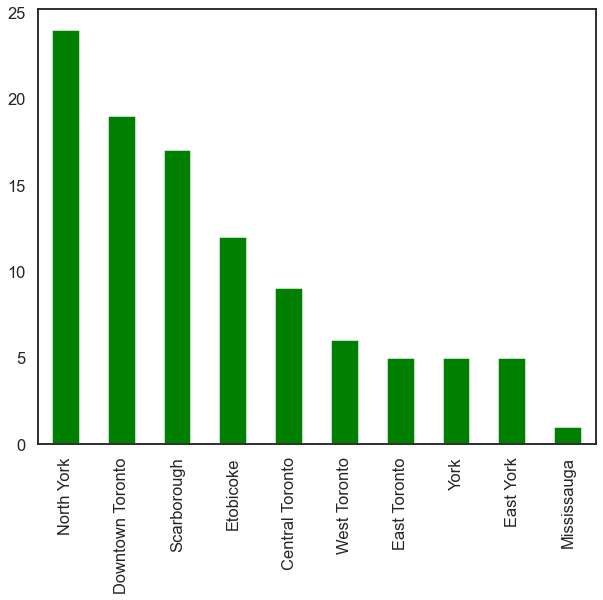

In [12]:
toronto_neighbourhood_by_postalcode_valid_df['borough'].value_counts().plot(kind='bar', color='g', figsize=(10,8))

In [13]:
toronto_neighbourhood_by_postalcode_valid_df.shape

(103, 3)

### Add longitude and latitude information

In [14]:
toronto_coordinate_file = 'https://raw.githubusercontent.com/ThoughtVector/coursera_ds/master/Geospatial_Coordinates.csv'
df_coordinates = pd.read_csv(toronto_coordinate_file)
df_coordinates.columns = ['postalcode','latitude','longitude']
print(df_coordinates.shape)
df_coordinates.head()

(103, 3)


,postalcode,latitude,longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


The following function using Geocoder is taking forever to finish. Hence using the coordinate file

```  
import geocoder 

def get_longitude_latitude(postal_code_series):
    coordinate_list = []
    postal_code_list = postal_code_series.values
    for postal_code in postal_code_list:
        coordinate_tuple = None
        while(coordinate_tuple is None):
            g = geocoder.google('{}, Toronto, Ontario'.format(postal_code))
            coordinate_tuple = g.latlng
        coordinate_list.append(coordinate_tuple)
    return coordinate_list

coordinate_tuples_list = get_longitude_latitude(toronto_neighbourhood_by_postalcode_valid_df['postalcode'])  
    
```

##### Note the following output is sorted lexicographically

In [15]:
toronto_neighbourhood_gis_df = toronto_neighbourhood_by_postalcode_valid_df.merge(df_coordinates, how = 'left', on = 'postalcode', sort = True)
print(toronto_neighbourhood_gis_df.shape)
toronto_neighbourhood_gis_df.head()

(103, 5)


,postalcode,borough,neighbourhood,latitude,longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


#### View the map of the neighbourhood

In [16]:
address = 'Toronto, ON, Canada'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [17]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto_neighbourhood_gis_df['latitude'], toronto_neighbourhood_gis_df['longitude'], 
                                                                           toronto_neighbourhood_gis_df['borough'], toronto_neighbourhood_gis_df['neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

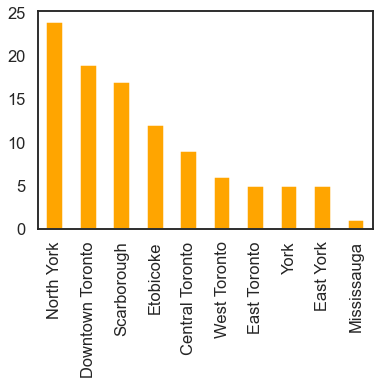

In [18]:
toronto_neighbourhood_gis_df['borough'].value_counts().plot(kind='bar', color = 'orange')

##### Given North York has the highest counts in the data frame, let us choose boroughs that contain 'York' in their name for exploration

In [19]:
york_df = toronto_neighbourhood_gis_df[(toronto_neighbourhood_gis_df['borough'] == 'North York') | 
                                                                                     (toronto_neighbourhood_gis_df['borough'] == 'East York') | 
                                                                                     (toronto_neighbourhood_gis_df['borough'] == 'York')].reset_index(drop=True)
print(york_df.shape)
york_df.head()

(34, 5)


,postalcode,borough,neighbourhood,latitude,longitude
0,M2H,North York,Hillcrest Village,43.803762,-79.363452
1,M2J,North York,"Fairview, Henry Farm, Oriole",43.778517,-79.346556
2,M2K,North York,Bayview Village,43.786947,-79.385975
3,M2L,North York,"York Mills, Silver Hills",43.757490,-79.374714
4,M2M,North York,"Willowdale, Newtonbrook",43.789053,-79.408493


In [20]:
locality_name = 'North York, ON, Canada'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(locality_name)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of the burough of North York are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of the burough of North York are 43.7543263, -79.44911696639593.


#### Visualize the neighbourhood of North York

In [21]:
# create map of Manhattan using latitude and longitude values
map_york = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(york_df['latitude'], york_df['longitude'], york_df['neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_york)  
    
map_york

#### Exploration of neighbourhood and segmentation

In [22]:
CLIENT_ID = 'GZSYRIBMEOWFNAFWP3QVONSLQJVIUMXGRFMIPB05JHMT3IMH' # your Foursquare ID
CLIENT_SECRET = 'CXLIISKNWYPSIXUFLMHOAZGPX4J2LV2WAMFRG40NSNYK4D2E' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: GZSYRIBMEOWFNAFWP3QVONSLQJVIUMXGRFMIPB05JHMT3IMH
CLIENT_SECRET:CXLIISKNWYPSIXUFLMHOAZGPX4J2LV2WAMFRG40NSNYK4D2E


In [23]:
neighborhood_latitude = york_df.loc[0, 'latitude'] # neighborhood latitude value
neighborhood_longitude = york_df.loc[0, 'longitude'] # neighborhood longitude value

neighborhood_name = york_df.loc[0, 'neighbourhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Hillcrest Village are 43.8037622, -79.3634517.


In [24]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 1000 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

In [25]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5f0ac3bf4c1ae841daa868de'},
 'response': {'headerLocation': 'Toronto',
  'headerFullLocation': 'Toronto',
  'headerLocationGranularity': 'city',
  'totalResults': 19,
  'suggestedBounds': {'ne': {'lat': 43.81276220900001,
    'lng': -79.35100467075661},
   'sw': {'lat': 43.79476219099999, 'lng': -79.37589872924339}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4bd9842be914a593adbd56fa',
       'name': 'Tastee',
       'location': {'address': '3913 Don Mills Rd.',
        'crossStreet': 'at Cliffwood Rd.',
        'lat': 43.80772211146167,
        'lng': -79.35679781099806,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.80772211146167,
          'lng': -79.35679781099806}],
        'distance': 692,
        'pos

In [26]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [27]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = pd.json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

print(nearby_venues.shape)

nearby_venues.head()

(19, 4)


,name,categories,lat,lng
0,Tastee,Bakery,43.807722,-79.356798
1,고려삼계탕 Korean Ginseng Chicken Soup & Bibimbap,Korean Restaurant,43.798391,-79.369187
2,Galati,Grocery Store,43.797831,-79.369410
3,Cummer Park,Park,43.799564,-79.371175
4,Tim Hortons,Coffee Shop,43.798945,-79.369644


In [28]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['neighbourhood', 
                  'neighbourhood latitude', 
                  'neighbourhood longitude', 
                  'venue', 
                  'venue latitude', 
                  'venue longitude', 
                  'venue category']
    
    return(nearby_venues)

In [37]:
york_venues_df = getNearbyVenues(names=york_df['neighbourhood'], latitudes=york_df['latitude'], longitudes=york_df['longitude'])
print(york_venues_df.shape)
york_venues_df.head()

Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
York Mills, Silver Hills
Willowdale, Newtonbrook
Willowdale, Willowdale East
York Mills West
Willowdale, Willowdale West
Parkwoods
Don Mills
Don Mills
Bathurst Manor, Wilson Heights, Downsview North
Northwood Park, York University
Downsview
Downsview
Downsview
Downsview
Victoria Village
Parkview Hill, Woodbine Gardens
Woodbine Heights
Leaside
Thorncliffe Park
East Toronto, Broadview North (Old East York)
Bedford Park, Lawrence Manor East
Lawrence Manor, Lawrence Heights
Glencairn
Humewood-Cedarvale
Caledonia-Fairbanks
North Park, Maple Leaf Park, Upwood Park
Del Ray, Mount Dennis, Keelsdale and Silverthorn
Runnymede, The Junction North
Humber Summit
Humberlea, Emery
Weston
(337, 7)


,neighbourhood,neighbourhood latitude,neighbourhood longitude,venue,venue latitude,venue longitude,venue category
0,Hillcrest Village,43.803762,-79.363452,Eagle's Nest Golf Club,43.805455,-79.364186,Golf Course
1,Hillcrest Village,43.803762,-79.363452,AY Jackson Pool,43.804515,-79.366138,Pool
2,Hillcrest Village,43.803762,-79.363452,Villa Madina,43.801685,-79.363938,Mediterranean Restaurant
3,Hillcrest Village,43.803762,-79.363452,Duncan Creek Park,43.805539,-79.360695,Dog Run
4,Hillcrest Village,43.803762,-79.363452,A.Y. Jackson Secondary School Track,43.805068,-79.366677,Athletics & Sports


In [38]:
print(york_venues_df.groupby('neighbourhood').count())
print('There are {} uniques categories.'.format(len(york_venues_df['venue category'].unique())))

                                                  neighbourhood latitude  \
neighbourhood                                                              
Bathurst Manor, Wilson Heights, Downsview North                       20   
Bayview Village                                                        4   
Bedford Park, Lawrence Manor East                                     24   
Caledonia-Fairbanks                                                    5   
Del Ray, Mount Dennis, Keelsdale and Silverthorn                       4   
Don Mills                                                             27   
Downsview                                                             15   
East Toronto, Broadview North (Old East York)                          3   
Fairview, Henry Farm, Oriole                                          64   
Glencairn                                                              5   
Hillcrest Village                                                      5   
Humber Summi

### Analysis of neighbourhoods

In [109]:
# one hot encoding
york_venues_onehot = pd.get_dummies(york_venues_df[['venue category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
york_venues_onehot['neighbourhood'] = york_venues_df['neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [york_venues_onehot.columns[-1]] + list(york_venues_onehot.columns[:-1])
york_venues_onehot = york_venues_onehot[fixed_columns]

print(york_venues_onehot.shape)
york_venues_onehot.head()

(337, 120)


,neighbourhood,Accessories Store,Airport,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Bagel Shop,Bakery,...,Thai Restaurant,Theater,Toy / Game Store,Trail,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Women's Store,Yoga Studio
0,Hillcrest Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Hillcrest Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Hillcrest Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Hillcrest Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Hillcrest Village,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [110]:
york_venues_onehot.columns

Index(['neighbourhood', 'Accessories Store', 'Airport', 'American Restaurant',
       'Art Gallery', 'Arts & Crafts Store', 'Asian Restaurant',
       'Athletics & Sports', 'Bagel Shop', 'Bakery',
       ...
       'Thai Restaurant', 'Theater', 'Toy / Game Store', 'Trail',
       'Video Game Store', 'Video Store', 'Vietnamese Restaurant',
       'Warehouse Store', 'Women's Store', 'Yoga Studio'],
      dtype='object', length=120)

In [111]:
york_venues_grouped = york_venues_onehot.groupby('neighbourhood').mean().reset_index()
print(york_venues_grouped.shape)
york_venues_grouped.head()

(29, 120)


,neighbourhood,Accessories Store,Airport,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Bagel Shop,Bakery,...,Thai Restaurant,Theater,Toy / Game Store,Trail,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Women's Store,Yoga Studio
0,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Bayview Village,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Bedford Park, Lawrence Manor East",0.0,0.0,0.041667,0.0,0.0,0.0,0.0,0.0,0.0,...,0.041667,0.0,0.041667,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Caledonia-Fairbanks,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.2,0.0
4,"Del Ray, Mount Dennis, Keelsdale and Silverthorn",0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### Create a data frame with common venues

In [112]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

In [113]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
york_neighbourhood_sorted = pd.DataFrame(columns=columns)
york_neighbourhood_sorted['neighbourhood'] = york_venues_grouped['neighbourhood']

for ind in np.arange(york_venues_grouped.shape[0]):
    york_neighbourhood_sorted.iloc[ind, 1:] = return_most_common_venues(york_venues_grouped.iloc[ind, :], num_top_venues)

print(york_neighbourhood_sorted.shape)
york_neighbourhood_sorted.head()

(29, 11)


,neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Bank,Fried Chicken Joint,Supermarket,Deli / Bodega,Sandwich Place,Bridal Shop,Shopping Mall,Middle Eastern Restaurant,Diner
1,Bayview Village,Chinese Restaurant,Café,Bank,Japanese Restaurant,Yoga Studio,Distribution Center,Construction & Landscaping,Convenience Store,Cosmetics Shop,Curling Ice
2,"Bedford Park, Lawrence Manor East",Coffee Shop,Restaurant,Sandwich Place,Sushi Restaurant,Italian Restaurant,Indian Restaurant,Comfort Food Restaurant,Café,Butcher,Pharmacy
3,Caledonia-Fairbanks,Park,Women's Store,Convenience Store,Bar,Distribution Center,Comfort Food Restaurant,Construction & Landscaping,Cosmetics Shop,Curling Ice,Deli / Bodega
4,"Del Ray, Mount Dennis, Keelsdale and Silverthorn",Discount Store,Sandwich Place,Bar,Skating Rink,Yoga Studio,Coffee Shop,Comfort Food Restaurant,Construction & Landscaping,Convenience Store,Cosmetics Shop


#### Clustering

In [114]:
# set number of clusters
kclusters = 6

york_places_grouped_for_clustering = york_venues_grouped.drop('neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=67).fit(york_places_grouped_for_clustering)

# check cluster labels generated for each row in the dataframe
print(kmeans.labels_[0:30] )

print(np.unique(kmeans.labels_, return_counts = True))

[3 3 3 0 3 3 3 0 3 1 3 1 4 3 3 3 5 3 3 0 1 3 3 0 2 3 3 3 0]
(array([0, 1, 2, 3, 4, 5]), array([ 5,  3,  1, 18,  1,  1], dtype=int64))


In [115]:
# add clustering labels
york_neighbourhood_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

york_merged = york_df

york_merged = york_merged.join(york_neighbourhood_sorted.set_index('neighbourhood'), on='neighbourhood')

york_merged.dropna(subset=['Cluster Labels'], inplace = True)
york_merged['Cluster Labels'] = york_merged['Cluster Labels'].astype('int')

In [119]:
print(york_merged.shape)
york_merged.head(35)

(33, 16)


,postalcode,borough,neighbourhood,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M2H,North York,Hillcrest Village,43.803762,-79.363452,3,Golf Course,Athletics & Sports,Pool,Mediterranean Restaurant,Dog Run,Fried Chicken Joint,Food Truck,Comfort Food Restaurant,Gastropub,Construction & Landscaping
1,M2J,North York,"Fairview, Henry Farm, Oriole",43.778517,-79.346556,3,Clothing Store,Coffee Shop,Fast Food Restaurant,Women's Store,Restaurant,Juice Bar,Food Court,Shoe Store,Bank,Japanese Restaurant
2,M2K,North York,Bayview Village,43.786947,-79.385975,3,Chinese Restaurant,Café,Bank,Japanese Restaurant,Yoga Studio,Distribution Center,Construction & Landscaping,Convenience Store,Cosmetics Shop,Curling Ice
4,M2M,North York,"Willowdale, Newtonbrook",43.789053,-79.408493,2,Piano Bar,Golf Course,Clothing Store,Coffee Shop,Comfort Food Restaurant,Construction & Landscaping,Convenience Store,Cosmetics Shop,Curling Ice,Deli / Bodega
5,M2N,North York,"Willowdale, Willowdale East",43.770120,-79.408493,3,Ramen Restaurant,Pizza Place,Café,Sandwich Place,Coffee Shop,Restaurant,Japanese Restaurant,Sushi Restaurant,Indonesian Restaurant,Bubble Tea Shop
6,M2P,North York,York Mills West,43.752758,-79.400049,0,Park,Convenience Store,Yoga Studio,Golf Course,Coffee Shop,Comfort Food Restaurant,Construction & Landscaping,Cosmetics Shop,Curling Ice,Deli / Bodega
7,M2R,North York,"Willowdale, Willowdale West",43.782736,-79.442259,3,Pizza Place,Bank,Coffee Shop,Discount Store,Pharmacy,Grocery Store,Fried Chicken Joint,Dim Sum Restaurant,Clothing Store,Gas Station
8,M3A,North York,Parkwoods,43.753259,-79.329656,0,Park,Bus Stop,Food & Drink Shop,Yoga Studio,Discount Store,Comfort Food Restaurant,Construction & Landscaping,Convenience Store,Cosmetics Shop,Curling Ice
9,M3B,North York,Don Mills,43.745906,-79.352188,3,Gym,Japanese Restaurant,Coffee Shop,Restaurant,Asian Restaurant,Beer Store,Dim Sum Restaurant,Italian Restaurant,Sandwich Place,Discount Store
10,M3C,North York,Don Mills,43.725900,-79.340923,3,Gym,Japanese Restaurant,Coffee Shop,Restaurant,Asian Restaurant,Beer Store,Dim Sum Restaurant,Italian Restaurant,Sandwich Place,Discount Store


In [120]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(york_merged['latitude'], york_merged['longitude'], york_merged['neighbourhood'], york_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

##### Cluster 1

In [129]:
york_merged.loc[york_merged['Cluster Labels'] == 0, york_merged.columns[[1] + list(range(3, york_merged.shape[1]))]]

,borough,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,North York,43.752758,-79.400049,0,Park,Convenience Store,Yoga Studio,Golf Course,Coffee Shop,Comfort Food Restaurant,Construction & Landscaping,Cosmetics Shop,Curling Ice,Deli / Bodega
8,North York,43.753259,-79.329656,0,Park,Bus Stop,Food & Drink Shop,Yoga Studio,Discount Store,Comfort Food Restaurant,Construction & Landscaping,Convenience Store,Cosmetics Shop,Curling Ice
22,East York,43.685347,-79.338106,0,Park,Convenience Store,Intersection,Yoga Studio,Discount Store,Coffee Shop,Comfort Food Restaurant,Construction & Landscaping,Cosmetics Shop,Curling Ice
27,York,43.689026,-79.453512,0,Park,Women's Store,Convenience Store,Bar,Distribution Center,Comfort Food Restaurant,Construction & Landscaping,Cosmetics Shop,Curling Ice,Deli / Bodega
33,York,43.706876,-79.518188,0,Park,Convenience Store,Yoga Studio,Golf Course,Coffee Shop,Comfort Food Restaurant,Construction & Landscaping,Cosmetics Shop,Curling Ice,Deli / Bodega


#### Cluster 2

In [130]:
york_merged.loc[york_merged['Cluster Labels'] == 1, york_merged.columns[[1] + list(range(3, york_merged.shape[1]))]]

,borough,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
25,North York,43.709577,-79.445073,1,Pizza Place,Bakery,Japanese Restaurant,Italian Restaurant,Pub,Dim Sum Restaurant,Dessert Shop,Department Store,Deli / Bodega,Curling Ice
30,York,43.673185,-79.487262,1,Pizza Place,Convenience Store,Bus Line,Chocolate Shop,Coffee Shop,Comfort Food Restaurant,Construction & Landscaping,Cosmetics Shop,Curling Ice,Deli / Bodega
31,North York,43.756303,-79.565963,1,Pizza Place,Italian Restaurant,Discount Store,Clothing Store,Coffee Shop,Comfort Food Restaurant,Construction & Landscaping,Convenience Store,Cosmetics Shop,Curling Ice


#### Cluster 3

In [131]:
york_merged.loc[york_merged['Cluster Labels'] == 2, york_merged.columns[[1] + list(range(3, york_merged.shape[1]))]]

,borough,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,North York,43.789053,-79.408493,2,Piano Bar,Golf Course,Clothing Store,Coffee Shop,Comfort Food Restaurant,Construction & Landscaping,Convenience Store,Cosmetics Shop,Curling Ice,Deli / Bodega


#### Cluster 4

In [132]:
york_merged.loc[york_merged['Cluster Labels'] == 3, york_merged.columns[[1] + list(range(3, york_merged.shape[1]))]]

,borough,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,North York,43.803762,-79.363452,3,Golf Course,Athletics & Sports,Pool,Mediterranean Restaurant,Dog Run,Fried Chicken Joint,Food Truck,Comfort Food Restaurant,Gastropub,Construction & Landscaping
1,North York,43.778517,-79.346556,3,Clothing Store,Coffee Shop,Fast Food Restaurant,Women's Store,Restaurant,Juice Bar,Food Court,Shoe Store,Bank,Japanese Restaurant
2,North York,43.786947,-79.385975,3,Chinese Restaurant,Café,Bank,Japanese Restaurant,Yoga Studio,Distribution Center,Construction & Landscaping,Convenience Store,Cosmetics Shop,Curling Ice
5,North York,43.770120,-79.408493,3,Ramen Restaurant,Pizza Place,Café,Sandwich Place,Coffee Shop,Restaurant,Japanese Restaurant,Sushi Restaurant,Indonesian Restaurant,Bubble Tea Shop
7,North York,43.782736,-79.442259,3,Pizza Place,Bank,Coffee Shop,Discount Store,Pharmacy,Grocery Store,Fried Chicken Joint,Dim Sum Restaurant,Clothing Store,Gas Station
9,North York,43.745906,-79.352188,3,Gym,Japanese Restaurant,Coffee Shop,Restaurant,Asian Restaurant,Beer Store,Dim Sum Restaurant,Italian Restaurant,Sandwich Place,Discount Store
10,North York,43.725900,-79.340923,3,Gym,Japanese Restaurant,Coffee Shop,Restaurant,Asian Restaurant,Beer Store,Dim Sum Restaurant,Italian Restaurant,Sandwich Place,Discount Store
11,North York,43.754328,-79.442259,3,Coffee Shop,Bank,Fried Chicken Joint,Supermarket,Deli / Bodega,Sandwich Place,Bridal Shop,Shopping Mall,Middle Eastern Restaurant,Diner
12,North York,43.767980,-79.487262,3,Coffee Shop,Caribbean Restaurant,Massage Studio,Bar,Miscellaneous Shop,Furniture / Home Store,Vietnamese Restaurant,Construction & Landscaping,Convenience Store,Diner
13,North York,43.737473,-79.464763,3,Park,Grocery Store,Bank,Business Service,Liquor Store,Discount Store,Shopping Mall,Baseball Field,Snack Place,Athletics & Sports


#### Cluster 5

In [133]:
york_merged.loc[york_merged['Cluster Labels'] == 4, york_merged.columns[[1] + list(range(3, york_merged.shape[1]))]]

,borough,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
32,North York,43.724766,-79.532242,4,Baseball Field,Yoga Studio,Distribution Center,Coffee Shop,Comfort Food Restaurant,Construction & Landscaping,Convenience Store,Cosmetics Shop,Curling Ice,Deli / Bodega


#### Cluster 6

In [134]:
york_merged.loc[york_merged['Cluster Labels'] == 5, york_merged.columns[[1] + list(range(3, york_merged.shape[1]))]]

,borough,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
28,North York,43.713756,-79.490074,5,Park,Construction & Landscaping,Trail,Bakery,Yoga Studio,Discount Store,Coffee Shop,Comfort Food Restaurant,Convenience Store,Cosmetics Shop
